In [1]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re

from catboost import CatBoostRegressor
from geopy.distance import geodesic
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
# Функция для преобразования формата скорости ветра

def extract_value(value):
    if isinstance(value, (int, float)):
        return value
    match = re.search(r'\((\d+\.\d+)\)', str(value))
    if match:
        return float(match.group(1))
    return value

In [3]:
# Функция загрузки и подготовки данных по нужным веществам из всех 6 геоточек

def load_data(num, all_substances):
    '''num - номер геоточки
       all_substances - названия загрязняющих веществ
    '''
    
    point = pd.read_excel(f'../data/raw/Усредненные_данные_Нижнекамск_т.{num}.xlsx')
    indexes = list(point.loc[0])
    indexes = indexes[1:]
    point = point.loc[3:].set_index('Интервал отбора')
    point.columns = indexes

    point = point.apply(lambda x: x.str.replace(',', '.'))
    point['V ветра, м/с'] = point['V ветра, м/с'].apply(extract_value)
    point[['Угол ветра, °', 'Направление ветра']] = point['D ветра, °'].str.extract(r'(\d+)\s?\((.+)\)')
    point['Направление ветра'].replace(np.NaN, 'Ш', inplace=True)
        
    # Пересечение множеств названий столбцов и substances
    substances = set(indexes) & set(all_substances)
    columns = [*substances, 'V ветра, м/с', 'Угол ветра, °', 'Направление ветра']
    point = point[columns]

    # Заполнение пропусков, если их в столбце не более 5%
    for col in point.columns:
        point[col] = pd.to_numeric(point[col], errors='ignore')
        if point[col].isna().sum().sum() / len(point) < 0.05:
            point[col].interpolate(inplace=True)
        
    return point

In [4]:
def melt_columns(df, substances, Mr):
    """Функция 'расплавления' столбцов с веществами"""
    
    df = pd.melt(df, id_vars=['V ветра, м/с', 'Угол ветра, °', 'Направление ветра'],
                value_vars=list(df.iloc[:, :-3]), ignore_index=False)

    # Закодируем названия веществ их молекулярной массой
    df.replace(substances, Mr, inplace=True)
    df.rename(columns={"variable": "Mr", "value": "C, мг/м³"}, inplace=True)

    df["Mr"] = pd.to_numeric(df["Mr"], errors='coerce')

    return df

In [5]:
def make_df(df, num, target_num):
    '''Функция предобработки датасета с предикторами
       num - номер геоточки
       target_num - номер точки, в которой модель будет считать концентрацию
    '''

    coor = locations_list[num - 1]
    target_coor = locations_list[target_num - 1]

    df = df.copy()
    df.dropna(inplace=True)
    df['lat'], df['lon'] = coor

    # Добавим расстояние от данной точки до точки c target_coor в качестве входной переменной
    df['distance, km'] = geodesic(coor, target_coor).km
    
    # Фичи c временными лагам
    for i in range(1, 5):
        df[f"V ветра_{i}"] = df['V ветра, м/с'].shift(i)
        df[f"Угол ветра_{i}"] = df['Угол ветра, °'].shift(i)
        df[f"C, мг/м³_{i}"] = df['C, мг/м³'].shift(i)
    df.dropna(inplace=True)

    return df

In [6]:
def split_scale_df(X, y):
    
    # Разбиваем
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
    
    # Масштабируем X
    scl = StandardScaler()
    scl.fit(X_train)
    X_train_scl = scl.transform(X_train)
    X_test_scl = scl.transform(X_test)

    return X_train_scl, X_test_scl, y_train, y_test

In [7]:
locations_list = [
    [55.539306, 051.856451],    # д. Клятле
    [55.622944, 051.825578],    # ул. Ахтубинская, 4б
    [55.650091, 051.852687],    # ул. Гагарина, 32
    [55.598983, 051.771936],    # ул. Юбилейная, 3
    [55.613193, 051.784821],    # ул. Южная, 3
    [55.654578, 051.800072]     # ул. Ямьле, 20
    ]

In [8]:
substances = ['CO, мг/м³',
              'NO, мг/м³',
              'NO2, мг/м³', 
              'NH3, мг/м³',
              'SO2, мг/м³',
              'H2S, мг/м³'
              ]
# Молекулярные массы веществ из substances
Mr = [28, 30, 46, 17, 64, 34]

Ранее модели определяли концентрации в геоточке №6, до нее из каждой точки рассчитывались растояния.  
Теперь же проделаем это все для каждой из точек: концентрации в каждой из шести точек по очереди будут целевыми концентрациями для остальных пяти точек, далее все датафреймы объединим в один.

In [9]:
point1 = load_data(1, substances)
point2 = load_data(2, substances)
point3 = load_data(3, substances)
point4 = load_data(4, substances)
point5 = load_data(5, substances)
point6 = load_data(6, substances)

points = [point1, point2, point3, point4, point5, point6]

In [10]:
df_melted_list = [melt_columns(df, substances, Mr) for df in points]

```
point1_melted = melt_columns(point1, substances, Mr)
point2_melted = melt_columns(point2, substances, Mr)
point3_melted = melt_columns(point3, substances, Mr)
point4_melted = melt_columns(point4, substances, Mr)
point5_melted = melt_columns(point5, substances, Mr)
point6_melted = melt_columns(point6, substances, Mr)

```
X1_5 = make_df(point1_melted, 1, 5)
X2_5 = make_df(point2_melted, 2, 5)
X3_5 = make_df(point3_melted, 3, 5)
X4_5 = make_df(point4_melted, 4, 5)
# X5_5
X6_5 = make_df(point6_melted, 6, 5)
X__5 = pd.concat([X1_5, X2_5, X3_5, X4_5, X6_5], axis=0)

In [12]:
def concat_dfs(df_melted_list, num):

    X_list = [make_df(df, i+1, num) for i, df in enumerate(df_melted_list)]
    del X_list[num - 1]    # удаляем сопоставление точки самой с собой
    X_num = pd.concat(X_list, axis=0)
    return X_num

X_1 = concat_dfs(df_melted_list, 1)
X_2 = concat_dfs(df_melted_list, 2)
X_3 = concat_dfs(df_melted_list, 3)
X_4 = concat_dfs(df_melted_list, 4)
X_5 = concat_dfs(df_melted_list, 5)
X_6 = concat_dfs(df_melted_list, 6)
X_num_list = [X_1, X_2, X_3, X_4, X_5, X_6]

# X_num_list = [concat_dfs(df_melted_list, j+1) for j in range(len(df_melted_list))]

689 отрицательных значений заменены на 0
MAE = 0.10853231984830662
CO, мг/м³

3639 отрицательных значений заменены на 0
MAE = 0.0030851366922088346
NO, мг/м³

1303 отрицательных значений заменены на 0
MAE = 0.006829422247950813
NO2, мг/м³

3980 отрицательных значений заменены на 0
MAE = 0.0009039412957164917
NH3, мг/м³

1319 отрицательных значений заменены на 0
MAE = 0.009570689251215115
SO2, мг/м³

221 отрицательных значений заменены на 0
MAE = 0.0007382467433282374
H2S, мг/м³



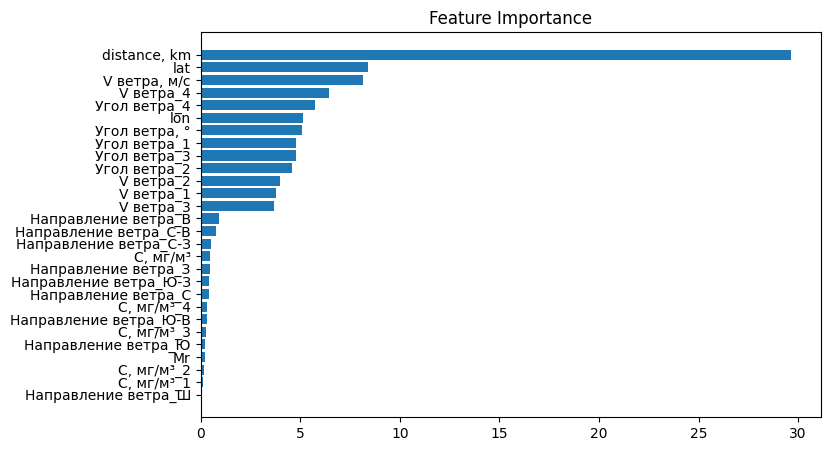

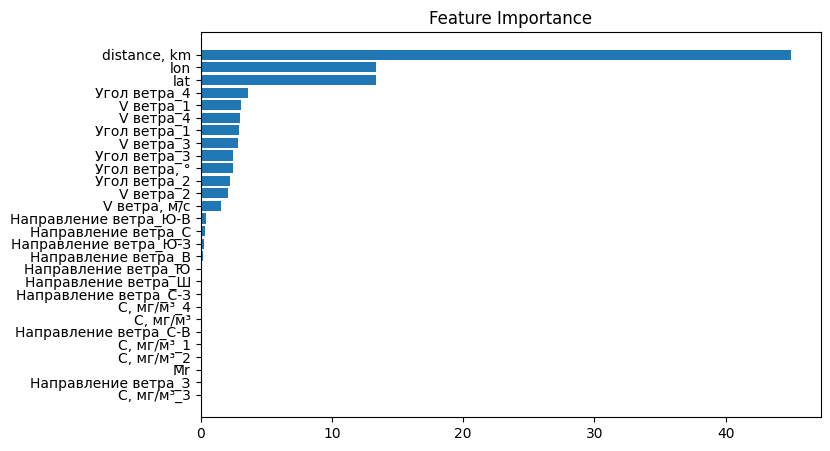

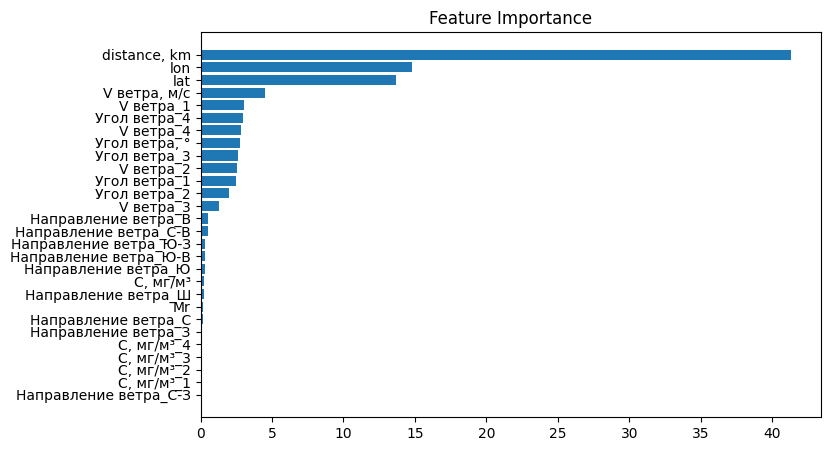

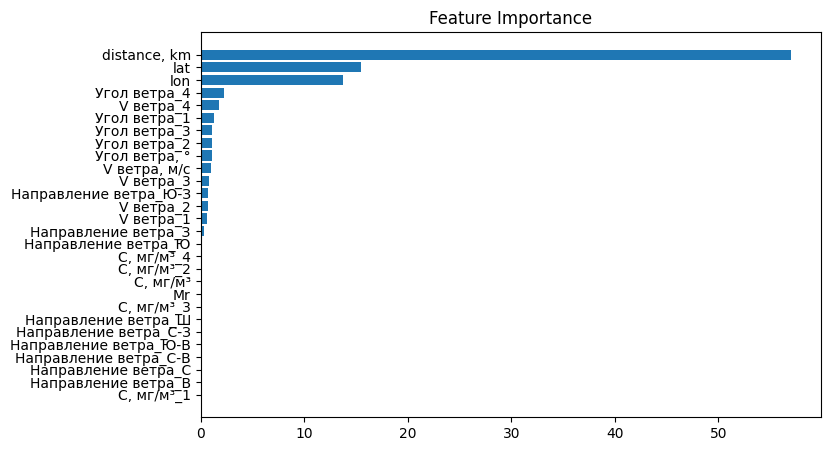

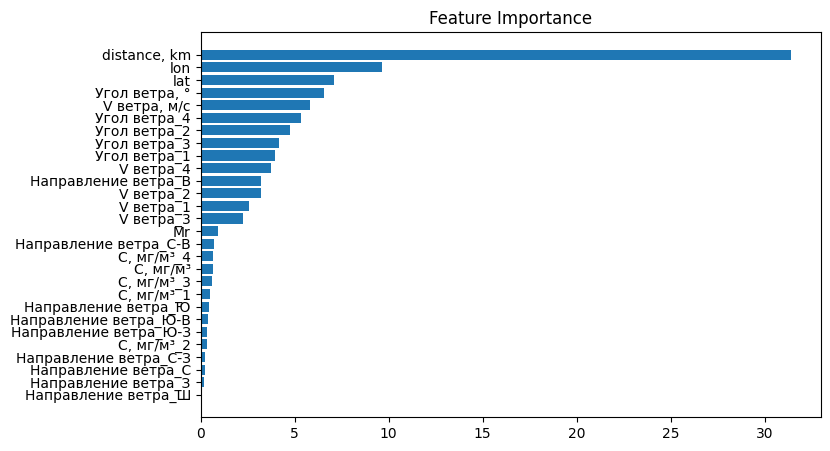

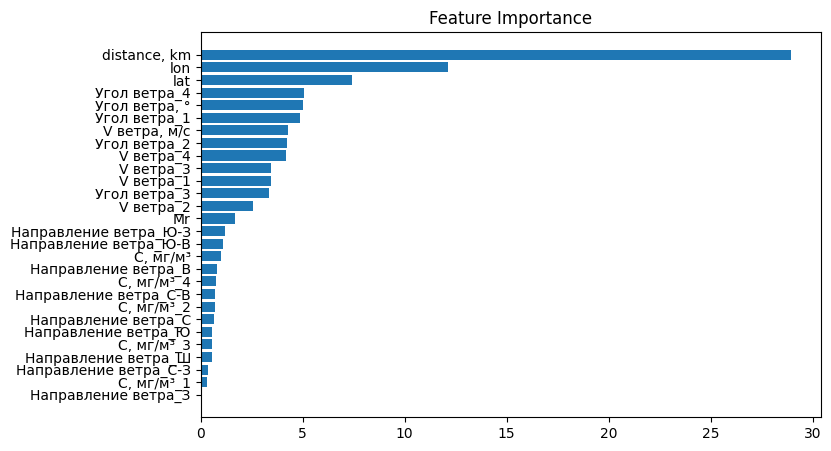

In [13]:
# Меняем таргет для нового обучения
for substance in substances:
    
    X_list_substance = copy.deepcopy(X_num_list)
    data_with_substance = []
    
    # Добавление целевой переменной
    for (num, X_num), point in zip(enumerate(X_list_substance), points):
        if substance in list(point):
            data_with_substance.append(X_num)
            data_with_substance[-1][f'target_{substance}'] = point[substance]
            
    # X_6[f'target_{substance}'] = point6[substance]
    # X_5[f'target_{substance}'] = point5[substance]
    # X_4[f'target_{substance}'] = point4[substance]
    # X_3[f'target_{substance}'] = point3[substance]
    # X_2[f'target_{substance}'] = point2[substance]
    # X_1[f'target_{substance}'] = point1[substance]

    # X = pd.concat([X_1, X_2, X_3, X_4, X_5, X_6], axis=0)
    X = pd.concat(data_with_substance, axis=0)
    X.dropna(inplace=True)
    X.drop_duplicates(inplace=True)
    X = pd.get_dummies(X, columns=['Направление ветра'])
    
    y = X.pop(f'target_{substance}')

    # Разбиваем и масштабируем
    X_train_scl, X_test_scl, y_train, y_test = split_scale_df(X, y)
    
    # Обучение
    cb = CatBoostRegressor(n_estimators=300, logging_level='Silent')
    cb.fit(X_train_scl, y_train)
    
    pred = cb.predict(X_test_scl)
    print((pred < 0).sum(), 'отрицательных значений заменены на 0')
    pred[pred < 0] = 0
    
    print('MAE =', mean_absolute_error(pred, y_test))
    print(substance)
    print()

In [ ]:
feature_importance = cb.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(8, 5))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X.columns)[sorted_idx])
plt.title('Feature Importance')